<a href="https://colab.research.google.com/github/gcaugant56/IA_DATA/blob/main/Projet_IA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Analyse et prétraitement

In [ ]:

#from google.colab import files
#uploaded = files.upload()


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score,  f1_score, mean_squared_error, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage 
import scipy.cluster.hierarchy as sch
import numpy as np





### 1. Calculez les corrélations entre les variables. Quelles sont variables les plus corrélées avec la cible (‘result’)? Expliquez les résultats. Si variable ‘result’ n’existe pas, utilisez une autre variable cible.

In [ ]:
col_list = ["age", "outcome","sex","chronic_disease_binary"]
data = pd.read_csv("covid2.csv",sep=";",error_bad_lines=False, usecols=col_list )
data=data.dropna()
data=data.reset_index()

outcomes = data["outcome"]
for i in range(0,len(data["outcome"])):
  mot = data["outcome"][i].lower()
  if mot == "death" or mot == "died" or mot == "deceased" or mot == "dead" :
    data["outcome"][i] = "dead"
  else:
    data["outcome"][i] = "alive"





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:

#one_hot1 = pd.get_dummies(data["country"])
outcome = pd.get_dummies(data["outcome"])
sex = pd.get_dummies(data["sex"])
chronic_disease_binary = pd.get_dummies(data["chronic_disease_binary"])

#data = data.drop("country",axis=1)
data = data.drop("sex",axis=1)
data = data.drop("chronic_disease_binary",axis=1)
data = data.drop("outcome",axis=1)

#data = data.join(one_hot1)
data = data.join(outcome)
data = data.join(sex)
data = data.join(chronic_disease_binary)

data.corr(method="pearson")



,index,age,alive,dead,female,male,False,True
index,1.000000,-0.401751,0.721019,-0.721019,0.124875,-0.124875,0.288470,-0.288470
age,-0.401751,1.000000,-0.578970,0.578970,-0.097231,0.097231,-0.192391,0.192391
alive,0.721019,-0.578970,1.000000,-1.000000,0.174477,-0.174477,0.205563,-0.205563
dead,-0.721019,0.578970,-1.000000,1.000000,-0.174477,0.174477,-0.205563,0.205563
female,0.124875,-0.097231,0.174477,-0.174477,1.000000,-1.000000,0.063211,-0.063211
male,-0.124875,0.097231,-0.174477,0.174477,-1.000000,1.000000,-0.063211,0.063211
False,0.288470,-0.192391,0.205563,-0.205563,0.063211,-0.063211,1.000000,-1.000000
True,-0.288470,0.192391,-0.205563,0.205563,-0.063211,0.063211,-1.000000,1.000000


### 2. Visualisez les données en deux dimensions en passant par l’ACP (analyse en composantes principales). Pouvez-vous utiliser une autre méthode ?

In [ ]:
pca = PCA(n_components=2)
data = data.drop(labels="dead",axis=1)
data =data.drop(labels="alive",axis=1)
component = pca.fit_transform(data)
principalDf = pd.DataFrame(data = component, columns = ['Component1', 'Component2'])
finalDf = pd.concat([principalDf, outcomes], axis = 1)

print(finalDf)

       Component1  Component2 outcome
0     3144.049598  -12.782973    dead
1     3143.099304  -22.787791    dead
2     3142.134023  -29.789764    dead
3     3141.079451  -18.797791    dead
4     3139.960198    5.196876    dead
...           ...         ...     ...
3046 -2045.876445  -40.571985    dead
3047 -2046.955864  -24.580087    dead
3048 -2047.806849  -54.581712    dead
3049 -2048.926023  -30.589936    dead
3050 -2050.005521  -14.595147   alive

[3051 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  FutureWarning,


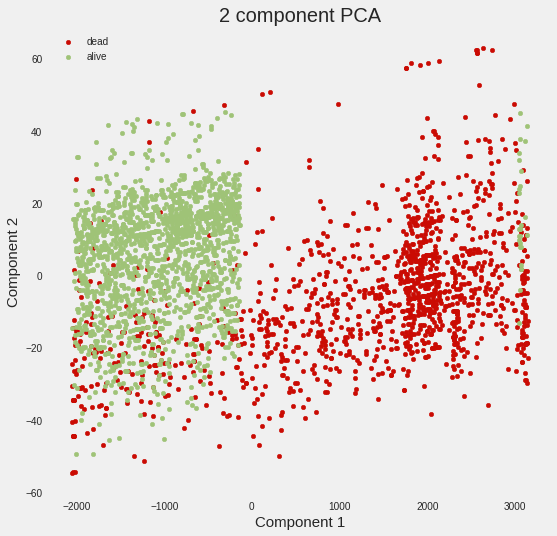

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['dead', 'alive']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['outcome'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Component1']
               , finalDf.loc[indicesToKeep, 'Component2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()

# II. Apprentissage artificiel

### 1. Dans la suite, nous utilisons une méthode d'apprentissage automatique afin de prédire la classe : les patients sont soit «décédés» (‘died’) soit «sortis» (‘discharged’) de l'hôpital. Vous pouvez utiliser la classification par K-Nearest Neighbours (K-NN), l’arbre de décision ou le classificateur Bayes.

In [ ]:
data = pd.concat([data, outcome], axis = 1)


#### KNN

In [ ]:
X = data.iloc[:, :-1].values
y = data.iloc[:, 6].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Text(0, 0.5, 'Mean Error')

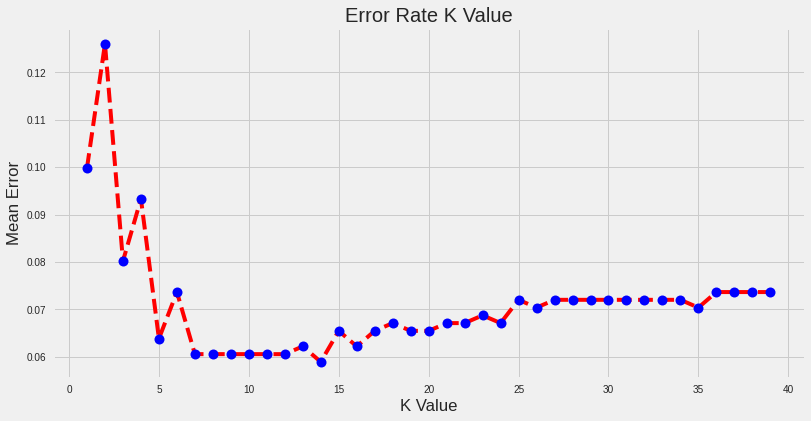

In [ ]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')



In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

### 2. Les résultats obtenus doivent être validés en utilisant certains indices externes comme l’erreur de prédiction (matrice de confusion et précision) ou d'autres comme Rappel, F-Measure, ...

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(classifier.score(X_test,y_test))

[[274   0]
 [  0 337]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       274
           1       1.00      1.00      1.00       337

    accuracy                           1.00       611
   macro avg       1.00      1.00      1.00       611
weighted avg       1.00      1.00      1.00       611

1.0


### 3. Utilisez la régression pour prédire l'âge (age) des personnes en fonction d'autres variables. Vous avez le choix sur ces variables explicatives ? Comment choisissez-vous ces variables ? Calculez la qualité de la prédiction à l'aide de l'erreur MSE (Mean Squared Error).

In [ ]:
newData = data.drop(labels="female", axis=1)
newData = newData.drop(labels="male", axis=1)
newData = newData.drop(labels="index", axis=1)

In [ ]:
#y --> age
#x --> True, False, dead, alive

y = newData["age"]
newData=newData.drop(labels="age",axis=1)
x=newData



In [ ]:
model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print("mean square error ", mean_squared_error(y_test,y_pred))
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


mean square error  0.0
coefficient of determination: 0.33929557122791676
intercept: 196327576828681.62
slope: [ 1.86243261e+13  1.86243261e+13 -2.14951903e+14 -2.14951903e+14]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  FutureWarning,


### 4. Appliquer trois méthodes de clustering (K-means, NMF et CAH) sur l'ensemble de données pour segmenter les personnes en différents groupes. Utilisez l'index de Silhouette pour connaître le meilleur nombre de clusters.


#### K-means

In [ ]:
sse = []
silhouette_coefficients = []
"""
scaler = StandardScaler()
scaler.fit(X_test)
scaledValues = scaler.transform(X_test)
print(y_test)
"""
for i in range(1,20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_test)
  sse.append(kmeans.inertia_)
  score = silhouette_score(X_test, y_test)
  silhouette_coefficients.append(score)



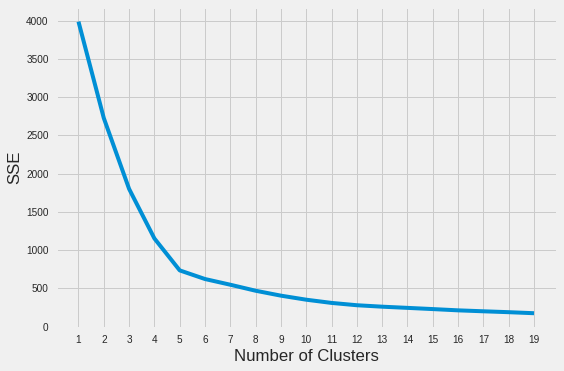

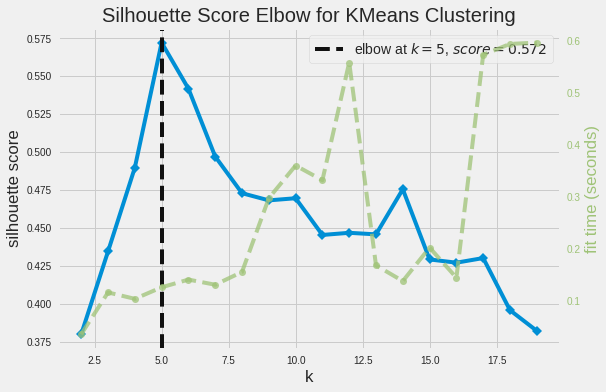

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(X_test)
visualizer.show() 

#### NMF

In [ ]:
"""
nmf = NMF(n_components=2)
nmf.fit(X_test)
J'arrive po 
"""


"\nnmf = NMF(n_components=2)\nnmf.fit(X_test)\nJ'arrive po \n"

#### CAH

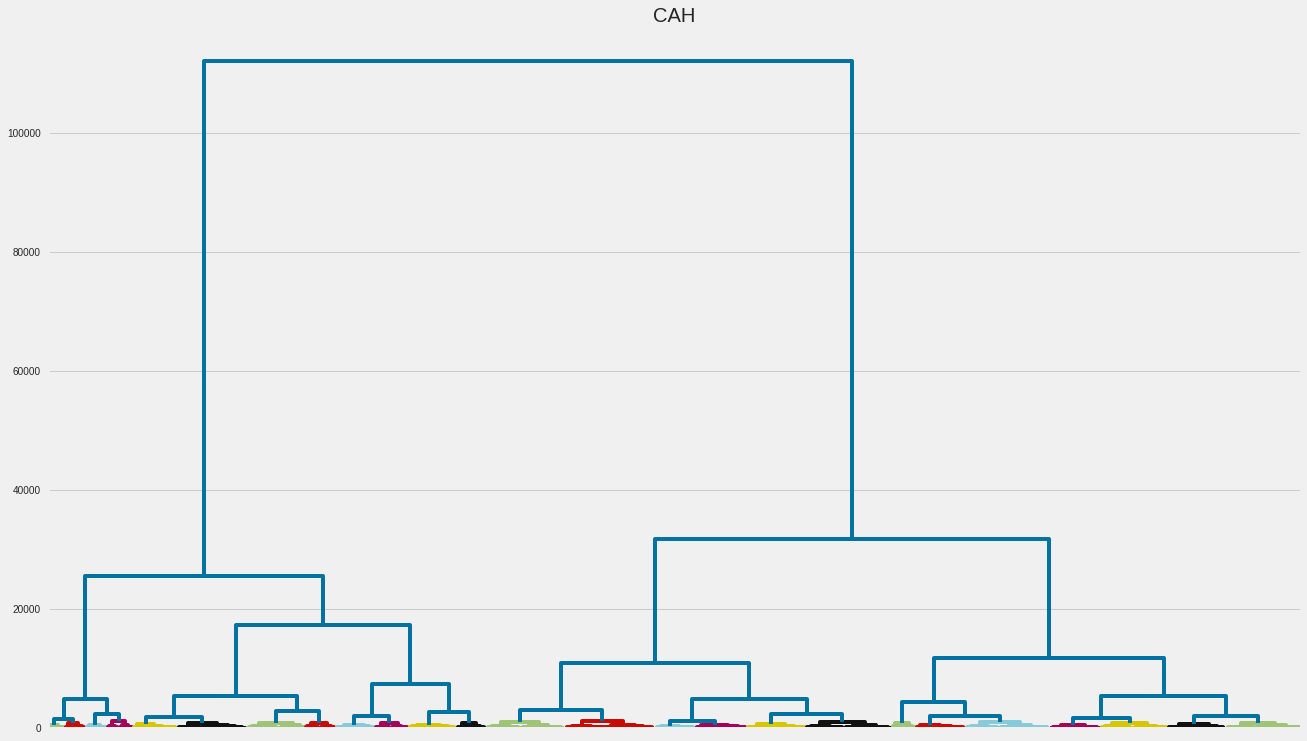

25 groupes constitués


In [ ]:
Z = linkage(data,method='ward',metric='euclidean') 

# génération et affichage du dendrogramme

plt.figure(figsize=(20,12))
plt.title("CAH") 

dendrogram(Z,no_labels=True,color_threshold=1200)

plt.show() 

groupes_cah = sch.fcluster(Z,t=1200,criterion='distance') 
print(np.unique(groupes_cah).size, "groupes constitués")

### 5. Visualisez les résultats pour analyser visuellement la structure de clustering des trois méthodes.

cf au dessus

### 6. Les données sont déséquilibrées. Vous pouvez les équilibrer en réduisant aléatoirement la classe majoritaire. Supposons que vous extrayez aléatoirement des échantillons équilibrés. Comment les résultats de la prédiction changeront-ils?

### 7. Comment pouvez-vous mieux gérer ce déséquilibre entre les classes ?


Réduire la classe dominante en supprimant aléatoirement des valeur ou augmente la class la plus faiblement représenté

### 8. Pour trouver les meilleurs paramètres pour les modèles, quel algorithme pouvez-vous utiliser. Expliquez l'algorithme.

# III. Architecture Map Reduce

### 1. Expliquez les propriété du challenge de « Big Data » concernant les données et la problématique du ce Projet

Le big data permet dans le cas du COVID-19, d'isoler certaine variables afin de connaitre les personnes qui seront le plus sensible au virus et pouvoir le comprendre

### 2. Présentez et expliquez l’avantage d’utiliser Spark par rapport à aux techniques classiques dans ce contexte.


Spark offre la possibilité de regrouper les exemples en groupe. Ce qui d'en notre cas nous permettra de placer des personnes dans des groupes et savoir quels sont les groupes les plus sensible au COVID-19

### 3. Ecrivez le pseudo code MapReduce d’une méthode de classification que vous avez utilisé.